# Advanced Certification Programme in AI and MLOps
## A programme by IISc and TalentSprint
### Mini-Project 1: Resume Classification

## Learning Objectives

At the end of the mini-project, you will be able to :

* perform data preprocessing, EDA and feature extraction on the Resume dataset
* perform multinomial Naive Bayes classification on the Resume dataset

### Dataset description

The data is in CSV format, with two features: Category, and Resume.

**Category** -  Industry sector to which the resume belongs to, and

**Resume** - The complete CV (text) of the candidate.

##  Grading = 10 Points

## Information

Companies often receive thousands of resumes for each job posting and employ dedicated screening officers to screen qualified candidates. Finding suitable candidates for an open role from a database of 1000s of resumes can be a tough task. Automated resume categorization can speeden the candidate selection process. Such automation can really ease the tedious process of fair screening and shortlisting the right candidates and aid quick decision making.

To learn more about this, click [here](https://www.sciencedirect.com/science/article/pii/S187705092030750X).

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score
from pandas.plotting import scatter_matrix
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib.gridspec import GridSpec
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Downloading the data

In [4]:
#@title Download the dataset
!wget -qq https://cdn.iisc.talentsprint.com/CDS/Datasets/UpdatedResumeDataSet.csv
print("Data Downloaded Successfuly!!")

Data Downloaded Successfuly!!


**Exercise 1: Read the UpdatedResumeDataset.csv dataset [0.5 Mark]**

**Hint:** pd.read_csv()

In [5]:
# read the dataset
df = pd.read_csv('UpdatedResumeDataSet.csv')
print(df.shape)
df.head(10)      # first 10 rows

(962, 2)


,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."
5,Data Science,"SKILLS C Basics, IOT, Python, MATLAB, Data Sci..."
6,Data Science,Skills â¢ Python â¢ Tableau â¢ Data Visuali...
7,Data Science,Education Details \r\n B.Tech Rayat and Bahr...
8,Data Science,Personal Skills â¢ Ability to quickly grasp t...
9,Data Science,Expertise â Data and Quantitative Analysis â...


### Pre-processing and EDA

**Exercise 2: Display  all the categories of resumes and their counts in the dataset [0.5 Mark]**



In [6]:
# Display the distinct categories of resume
df['Category'].unique()

array(['Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing'],
      dtype=object)

In [7]:
# Display the distinct categories of resume and the number of records belonging to each category
df['Category'].value_counts()

Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
ETL Developer                40
Operations Manager           40
Data Science                 40
Sales                        40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
SAP Developer                24
Civil Engineer               24
Advocate                     20
Name: Category, dtype: int64

**Exercise 3: Create the count plot of different categories [0.5 Mark]**

**Hint:** Use `sns.countplot()`

<Axes: xlabel='count', ylabel='Category'>

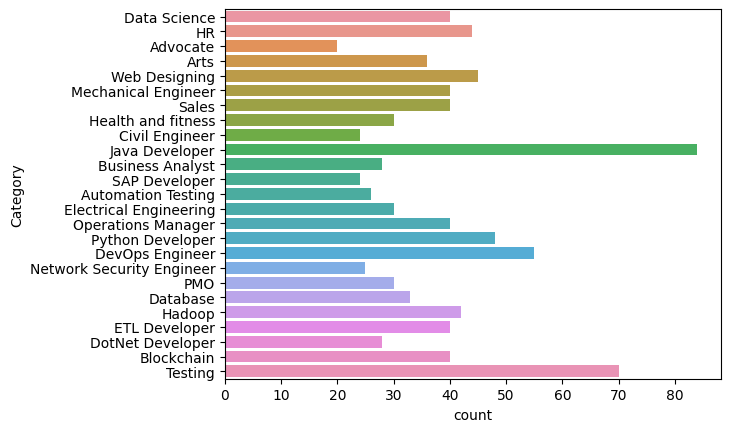

In [8]:
sns.countplot(y = df['Category'], data = df['Resume'])

**Exercise 4: Create a pie plot depicting the percentage of resume distributions category-wise [0.5 mark]**

**Hint:** Use [plt.pie()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pie.html) and [plt.get_cmap](https://matplotlib.org/stable/tutorials/colors/colormaps.html) for color mapping the pie chart.

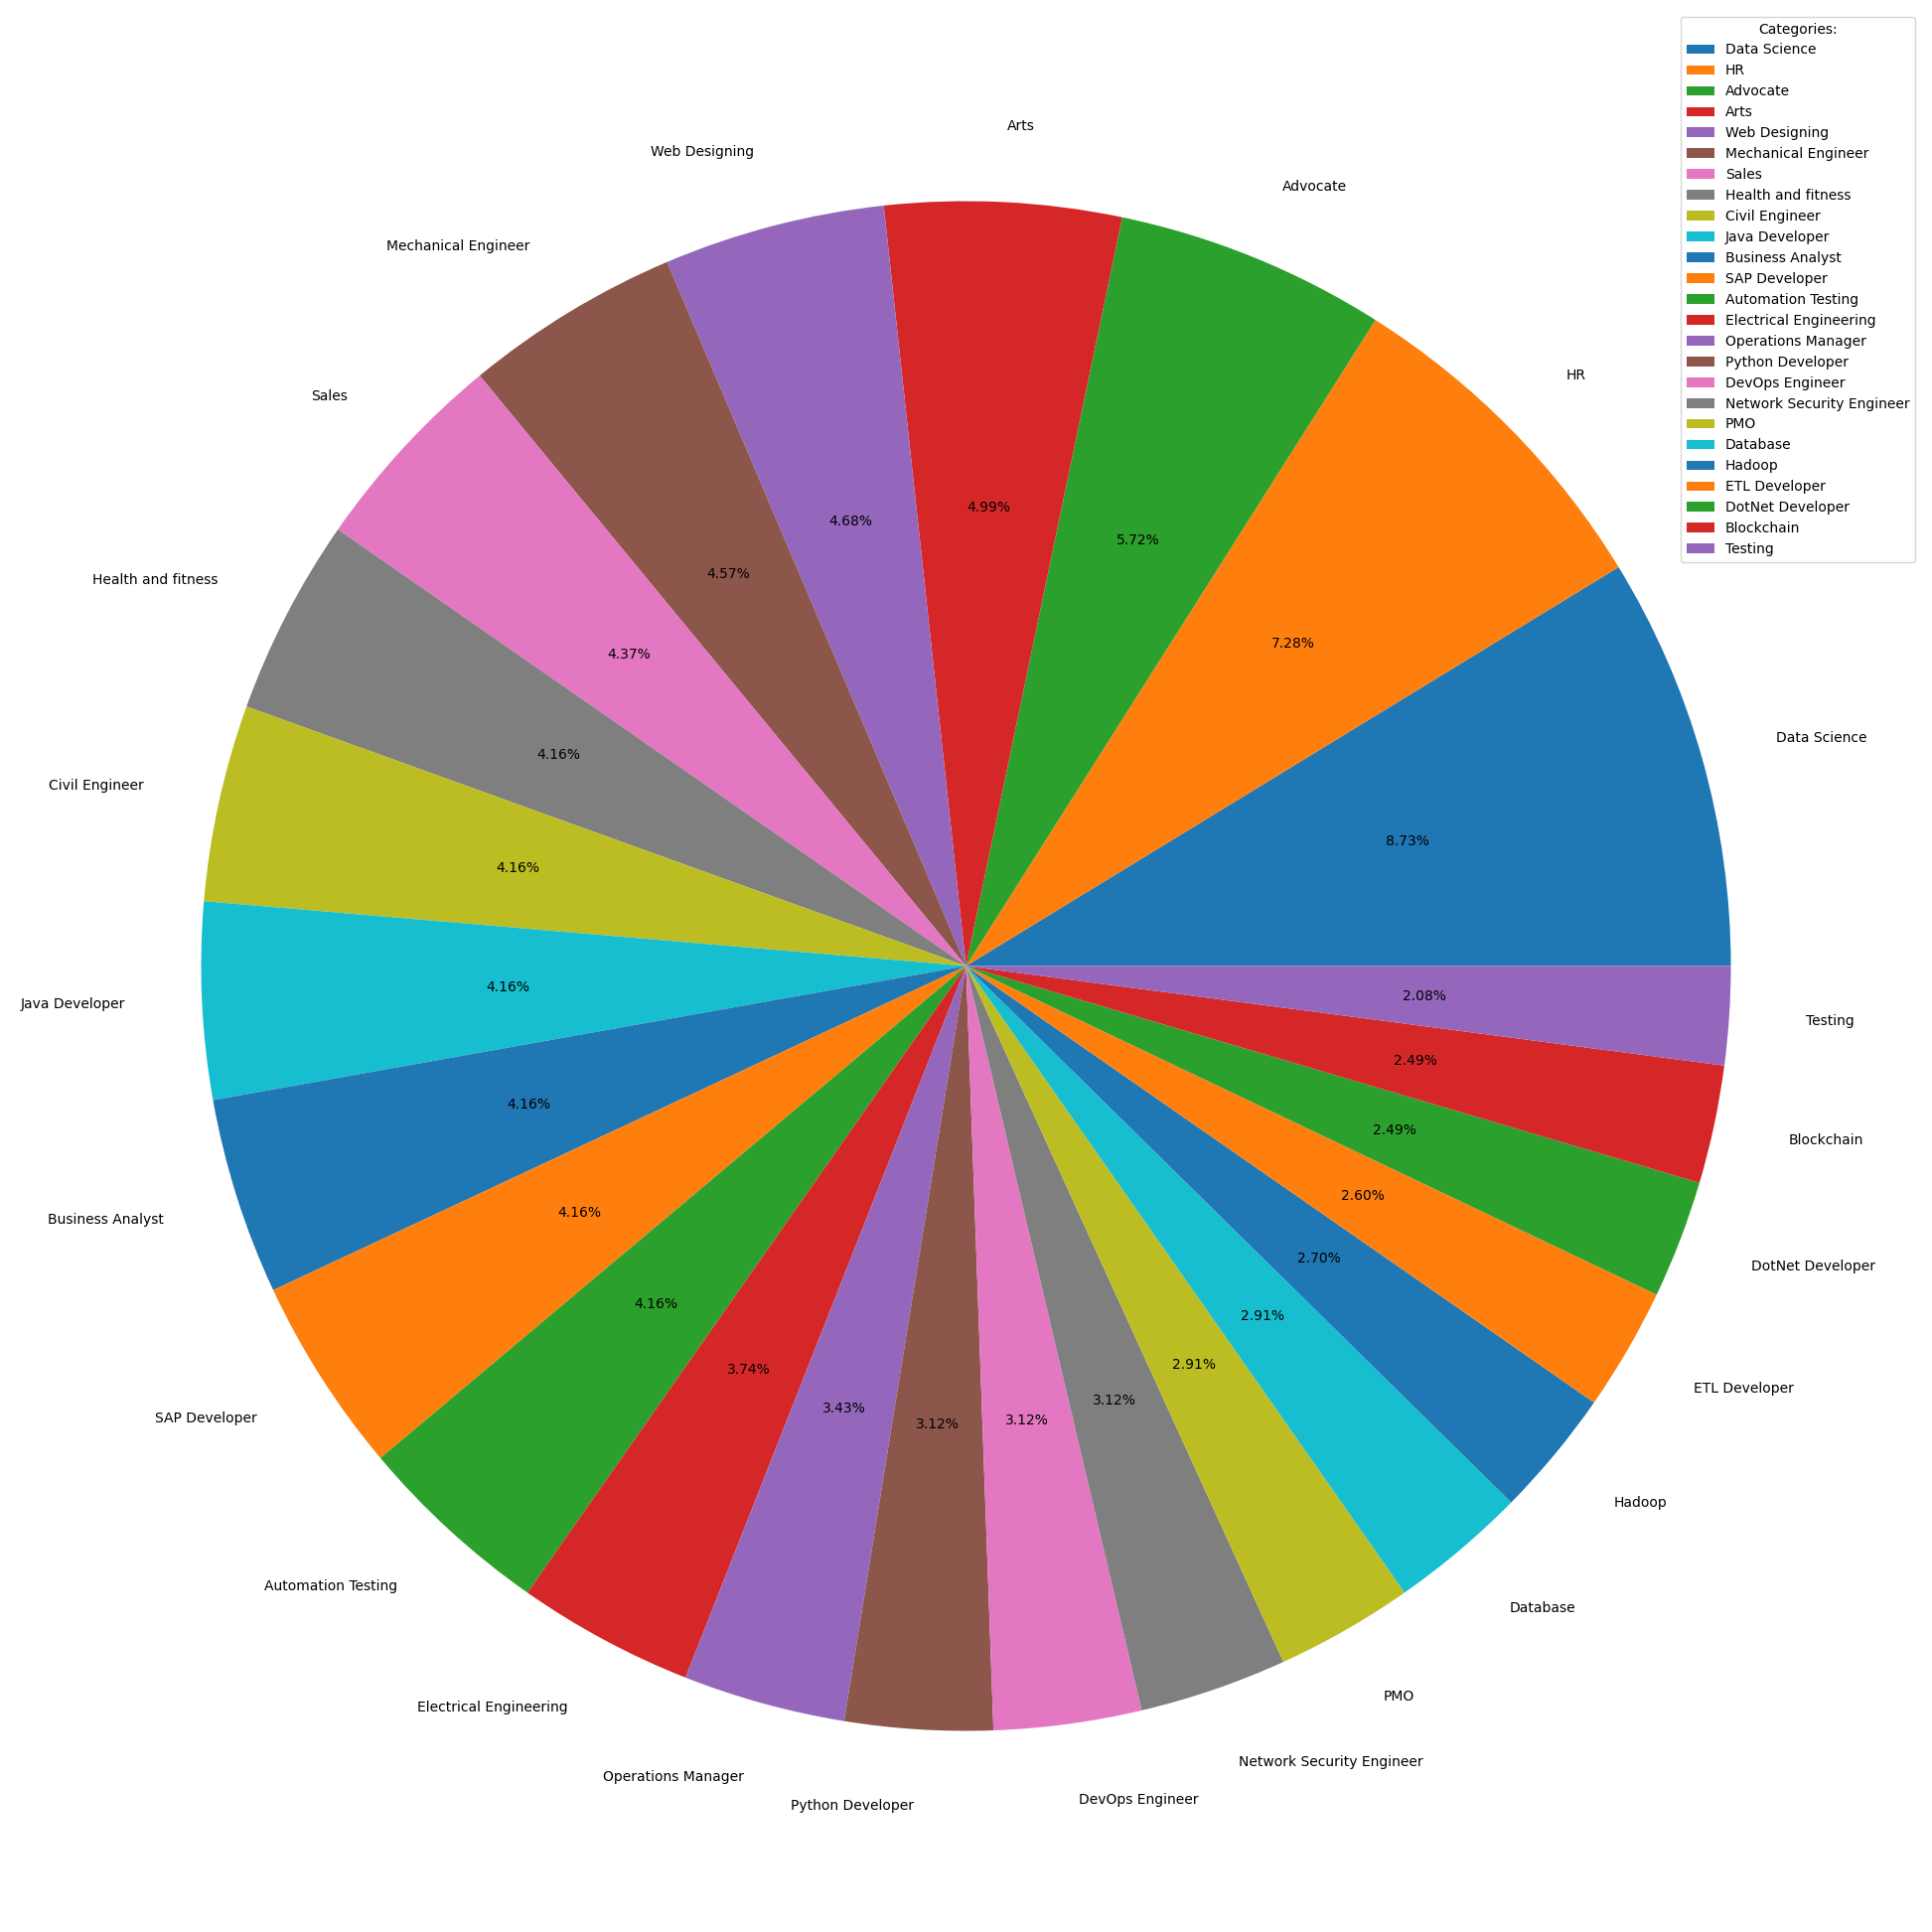

In [9]:
import matplotlib.pyplot as plt

targetCounts = df['Category'].value_counts()
targetLabels  = df['Category'].unique()
# Make square figures and axes
plt.figure(1, figsize=(25,25))
the_grid = GridSpec(2,2)
plt.pie(targetCounts, labels=targetLabels, autopct='%1.2f%%',shadow=False)

plt.legend(title = "Categories:")


**Exercise 5: Convert all the `Resume` text to lower case [0.5 Mark]**




In [10]:
# Convert all characters to lowercase
def convert_lower(text):
    return text.lower()

df['Resume'] = df['Resume'].apply(convert_lower)

In [11]:
#Check if converted to lower case
df['Resume'].head()

0    skills * programming languages: python (pandas...
1    education details \r\nmay 2013 to may 2017 b.e...
2    areas of interest deep learning, control syste...
3    skills â¢ r â¢ python â¢ sap hana â¢ table...
4    education details \r\n mca   ymcaust,  faridab...
Name: Resume, dtype: object

### Cleaning resumes' text data

**Exercise 6: Define a function to clean the resume text [2 Mark]**

In the text there are special characters, urls, hashtags, mentions, etc. Remove the following:  

* URLs: For reference click [here](https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python)
* RT | cc: For reference click [here](https://www.machinelearningplus.com/python/python-regex-tutorial-examples/)
* Hashtags, # and Mentions, @
* punctuations
* extra whitespace

PS: Use the provided reference similarly for removing any other such elements.

After cleaning as above, store the Resume Text in a separate column (New Feature).


In [12]:
import re
def cleanResume(resumeText):
  resumeText = re.sub(r'http\S+', '', resumeText,flags = re.MULTILINE) # remove URLs
  resumeText = re.sub('RT|cc', '', resumeText)  # remove RT and cc
  resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
  resumeText = re.sub('@\S+', '', resumeText)  # remove mentions
  resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', resumeText)  # remove punctuations
  resumeText = re.sub('â\S+', '', resumeText)  # remove â¢
  resumeText = re.sub('+', '', resumeText)  # remove 
  resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace

  return resumeText

In [13]:
 # apply the function defined above and save the
df['cleaned_resume'] = df['Resume'].apply(cleanResume)

In [14]:
sent_lens = []
for i in df.cleaned_resume:
    length = len(i.split())
    sent_lens.append(length)

print(len(sent_lens))
print(max(sent_lens))

962
2014


In [15]:
df[['Resume','cleaned_resume']].head()

,Resume,cleaned_resume
0,skills * programming languages: python (pandas...,skills programming languages python pandas num...
1,education details \r\nmay 2013 to may 2017 b.e...,education details may 2013 to may 2017 be uitr...
2,"areas of interest deep learning, control syste...",areas of interest deep learning control system...
3,skills â¢ r â¢ python â¢ sap hana â¢ table...,skills r python sap hana tableau sap hana sql ...
4,"education details \r\n mca ymcaust, faridab...",education details mca ymcaust faridabad haryan...


### Stopwords removal

The stopwords, for example, `and, the, was, and so forth` etc. appear very frequently in the text and are not helpful in the predictive process. Therefore these are usually removed for text analytics and text classification purposes.

1. Tokenize the input words into individual tokens and store it in an array
2. Using `nltk.corpus.stopwords`, remove the stopwords

Hint: See Module 1 - Assignment 4 'Text Classification using Naive Bayes'


**Exercise 7: Use `nltk` package to find the most common words from the `cleaned resume` column [2 Marks]**

**Hint:**
* Use `nltk.FreqDist`


In [16]:
# stop words
stopword_list = nltk.corpus.stopwords.words('english')
print(stopword_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [17]:
# removing the stopwords
from nltk.tokenize import word_tokenize

def remove_stopwords(text, is_lower_case=False):
    # splitting strings into tokens (list of words)
    tokens = word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [18]:
# apply function on cleaned resume to remove stopwords
df['cleaned_resume'] = df['cleaned_resume'].apply(remove_stopwords)

In [19]:
df[['Resume','cleaned_resume']].head()

,Resume,cleaned_resume
0,skills * programming languages: python (pandas...,skills programming languages python pandas num...
1,education details \r\nmay 2013 to may 2017 b.e...,education details may 2013 may 2017 uitrgpv da...
2,"areas of interest deep learning, control syste...",areas interest deep learning control system de...
3,skills â¢ r â¢ python â¢ sap hana â¢ table...,skills r python sap hana tableau sap hana sql ...
4,"education details \r\n mca ymcaust, faridab...",education details mca ymcaust faridabad haryan...


In [88]:
from nltk.probability import FreqDist

word_token_array = []
for row in df['cleaned_resume']:
  for token in word_tokenize(row):
    word_token_array.append(token)

print(len(word_token_array))
fdist = FreqDist(word_token_array)
print(fdist)

df1 = pd.DataFrame(list(fdist.items()), columns = ["Word","Frequency"])
df1.sort_values(by=['Frequency'],ascending=False).head(10)

311877
<FreqDist with 8022 samples and 311877 outcomes>


,Word,Frequency
84,exprience,3829
89,company,3536
520,project,3353
86,months,3283
90,description,3122
74,details,3096
75,data,2125
506,management,1989
108,team,1922
333,1,1847


<function matplotlib.pyplot.show(close=None, block=None)>

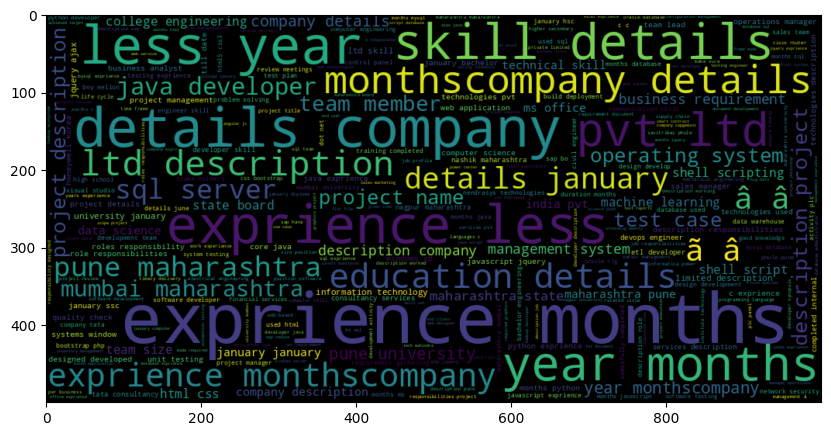

In [21]:
# YOUR CODE HERE to show the most common word using WordCloud
plt.figure(figsize=(10,10))
df_resume =  df[['cleaned_resume']]
resume_text = ' '.join(cleaned_resume for cleaned_resume in df_resume.cleaned_resume)
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
resume_words = WC.generate(resume_text)
plt.imshow(resume_words, interpolation='bilinear')
plt.show


**Exercise 8: Convert the categorical variable `Category` to a numerical feature and make a different column, which can be treated as the target variable [0.5 Mark]**

**Hint:** Use [`sklearn.preprocessing.LabelEncoder()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) method

In [22]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df['Category'])
df['Target'] = le.transform(df['Category'])
df

,Category,Resume,cleaned_resume,Target
0,Data Science,skills * programming languages: python (pandas...,skills programming languages python pandas num...,6
1,Data Science,education details \r\nmay 2013 to may 2017 b.e...,education details may 2013 may 2017 uitrgpv da...,6
2,Data Science,"areas of interest deep learning, control syste...",areas interest deep learning control system de...,6
3,Data Science,skills â¢ r â¢ python â¢ sap hana â¢ table...,skills r python sap hana tableau sap hana sql ...,6
4,Data Science,"education details \r\n mca ymcaust, faridab...",education details mca ymcaust faridabad haryan...,6
...,...,...,...,...
957,Testing,computer skills: â¢ proficient in ms office (...,computer skills proficient ms office word basi...,23
958,Testing,â willingness to accept the challenges. â ...,willingness aept challenges positive thinking ...,23
959,Testing,"personal skills â¢ quick learner, â¢ eagerne...",personal skills quick learner eagerness learn ...,23
960,Testing,computer skills & software knowledge ms-power ...,computer skills software knowledge mspower poi...,23


### Feature Extraction

**Exercise 9: Convert the text to feature vectors by applying `tfidf vectorizer` to the Label encoded category made above [2 Marks]**

`TF-IDF`will tokenize documents, learn the vocabulary, inverse document frequency weightings, and allow you to encode new documents

**Hint:** Use [`TfidfVectorizer()`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).



In [23]:
# tfidf vectorizer
tv = TfidfVectorizer(sublinear_tf=True,
    stop_words='english',
    max_features=1500)
#transformed train reviews
tfidf_resumes = tv.fit_transform(df['cleaned_resume'])
print('Tfidf_train:', tfidf_resumes.shape)

Tfidf_train: (962, 1500)


## Naive Bayes Classifier

**Exercise 10: Split the data into train and test sets. Apply Naive Bayes Classifier (MultinomialNB) and evaluate the model predictions [1 mark]**

**Hint:** Use Vectorized features made above as X and Labelled category as y.

In [24]:
# Split into training and testing set
X_train, X_test, y_train, y_test = train_test_split(tfidf_resumes, df['Target'], test_size = 0.2, random_state = 0)

In [25]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(769, 1500)
(193, 1500)
(769,)
(193,)


In [26]:
# training the model
mnb = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

# fitting the NaiveBayes for tfidf features
mnb_tfidf = mnb.fit(X_train, y_train)

print('MultinomialNB for tf-idf :', mnb_tfidf)

MultinomialNB for tf-idf : MultinomialNB()


In [27]:
# predicting the model for tfidf features
mnb_tfidf_predict = mnb.predict(X_test)
print('predictions for tf-idf :', mnb_tfidf_predict)

predictions for tf-idf : [20 14 15 17 15 14 10 14 15 23  6 23  4 11 13  4 19  8  8 15 12 11 17 22
 19 16  5  8  3 15 20 18 22  7 23 23 22 18  6 20 10 20 14  8 15 15  8 11
  4 22  1 24 14 15 22 23  8 15  3 17 18  3  0 15 15 15 16 21 13 18 12 23
 22 12 13 22  8  6 19 15 24 14  7  1 24 13 12 10  9  8 22 15 23 11  9 23
 11 15 23 13  4 17  2  5  6 10  0 19 20 10 22 10 15 10 15 15 22 15 14  6
  1  4  5  7  9 13 23  6 15  9 21 11  5  3 15 24 19 13  8  3 13 13 11 20
 16 23 21 24  7 21 20 15 22 19 15 23  9 15 15  6  2 20  7 11 23 24  8  3
 20  2 10 22 15  2 11 23  1 23  6  3  3 24 24 12  5 23 18 22 20 20  3  6
 15]


In [28]:
# accuracy score for tf-idf
mnb_tfidf_score = accuracy_score(y_test, mnb_tfidf_predict)
print("mnb_tfidf_score :", mnb_tfidf_score)

mnb_tfidf_score : 0.9378238341968912


## Optional: Create a Gradio based web interface to test and display the model predictions

**Report Analysis**
- Which method(s), other than TF-IDF could be used for text to vector conversion?
- Discuss about the `alpha`, `class_prior` and `fit_prior` parameters in sklearn `MultinomialNB`


Dataset Source Reference: [Resume dataset](https://www.kaggle.com/gauravduttakiit/resume-dataset/download)

In [29]:
!pip -qq install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.2/294.2 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 5.8 MB/s eta 0:

In [30]:
import gradio

In [31]:
# Function for preprocessing of text

def preprocess_text(text):
    text = cleanResume(text)
    return text

In [32]:
#pd.concat([df['Category'],df['Target']]).unique()
Target_Category = df[['Category', 'Target']].drop_duplicates()
print(Target_Category)

                      Category  Target
0                 Data Science       6
40                          HR      12
84                    Advocate       0
104                       Arts       1
140              Web Designing      24
185        Mechanical Engineer      16
225                      Sales      22
265         Health and fitness      14
295             Civil Engineer       5
319             Java Developer      15
403           Business Analyst       4
431              SAP Developer      21
455         Automation Testing       2
481     Electrical Engineering      11
511         Operations Manager      18
551           Python Developer      20
599            DevOps Engineer       8
654  Network Security Engineer      17
679                        PMO      19
709                   Database       7
742                     Hadoop      13
784              ETL Developer      10
824           DotNet Developer       9
852                 Blockchain       3
892                    Te

In [50]:
Target_Category[Target_Category['Target']==6]['Category'].to_list()

['Data Science']

In [54]:
# Function to predict label for a review

def predict_review_label(text, vectorizer_method):

    processed_text = preprocess_text(text)
    review = tv.transform([processed_text])
    pred = mnb_tfidf.predict(review)

    return Target_Category[Target_Category['Target']==pred[0]]['Category'].to_list()


In [55]:
# Testing a review
predict_review_label("Mechanical companies", 'TFIDFVectorizer')

['Mechanical Engineer']

In [56]:
# Dropdown choices
in_vectorizer_dropdown = gradio.inputs.Dropdown(['TFIDFVectorizer'], type="value", default=None, label='Choose a Method to Vectorize')

In [57]:
# Input from user
in_review = gradio.inputs.Textbox(lines=2, placeholder=None, default="resume", label='Enter the resume Text')

In [58]:
# Output prediction
out_label = gradio.outputs.Textbox(type="text", label='Predicted Resume Category')

In [59]:
# Gradio interface to generate UI link

iface = gradio.Interface(fn = predict_review_label,
                         inputs = [in_review, in_vectorizer_dropdown],
                         outputs = [out_label])

iface.launch(share = True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://b1f76bd91048c80109.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
